In [5]:
import requests 
import pandas as pd
import time
from more_itertools import chunked
from tqdm import tqdm 
from sturdystats import Index

api_key = "ktest2"
BASE = "http://localhost:8050/api/text/v1/index"
BASE = "https://sturdystatistics.com/api/text/v1/index"

NAME = "hacker_news_comments_v12"

#index = Index(api_key, NAME, _base_url=BASE)


In [125]:
index = Index(api_key, id="index_4750334255624ff7add4de8892bd1b35")

Found an existing index with id="index_4750334255624ff7add4de8892bd1b35".


In [127]:
import pandas as pd
pd.DataFrame(
    index.queryMeta("SELECT ticker, quarter FROM doc_meta where form_type='10-Q' ORDER BY ticker,quarter")
)

,ticker,quarter
0,AAPL,2022Q4
1,AAPL,2023Q2
2,AAPL,2023Q3
3,AAPL,2023Q4
4,AAPL,2024Q1
5,AAPL,2024Q2
6,AMZN,2022Q3
7,AMZN,2023Q1
8,AMZN,2023Q2
9,AMZN,2023Q3


In [6]:
bIndex(api_key, "weafwefawefawefw", _base_url=BASE)

Created new index with id="index_ae38838e439746a7b4ea6ee1befeef13".


In [7]:
" wow ".join([])

''

In [119]:
set(df.y.unique())

{Timestamp('2024-01-01 00:00:00'), Timestamp('2024-12-01 00:00:00')}

In [122]:
import numpy as np
set(np.argsort([10, 12, 113, 3]))

{0, 1, 2, 3}

In [124]:
[df.x.sum()

21

In [8]:
import pandas as pd

In [68]:
df = pd.DataFrame({"x": [1,2,3,4,5,6], "y": ["2024-01-01"]*3+["2024-12-01"]*3})
df["y"] = df.y.apply(pd.Timestamp)

In [79]:
pd.cut(df.y, 14, precision=1)

0    (2023-12-31 15:57:36, 2024-01-24 22:17:08.5714...
1    (2023-12-31 15:57:36, 2024-01-24 22:17:08.5714...
2    (2023-12-31 15:57:36, 2024-01-24 22:17:08.5714...
3    (2024-11-07 01:42:51.428571428, 2024-12-01 00:...
4    (2024-11-07 01:42:51.428571428, 2024-12-01 00:...
5    (2024-11-07 01:42:51.428571428, 2024-12-01 00:...
Name: y, dtype: category
Categories (14, interval[datetime64[ns], right]): [(2023-12-31 15:57:36, 2024-01-24 22:17:08.5714... < (2024-01-24 22:17:08.571428571, 2024-02-17 20:... < (2024-02-17 20:34:17.142857143, 2024-03-12 18:... < (2024-03-12 18:51:25.714285714, 2024-04-05 17:... ... (2024-08-27 06:51:25.714285716, 2024-09-20 05:... < (2024-09-20 05:08:34.285714288, 2024-10-14 03:... < (2024-10-14 03:25:42.857142856, 2024-11-07 01:... < (2024-11-07 01:42:51.428571428, 2024-12-01 00:...]

In [85]:
df.resample('M', on='y').sum().reset_index()


/var/folders/xl/1zzpgb891b9g2yppjn5xzv5w0000gp/T/ipykernel_64040/999027647.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample('M', on='y').sum().reset_index()


,y,x
0,2024-01-31,6
1,2024-02-29,0
2,2024-03-31,0
3,2024-04-30,0
4,2024-05-31,0
5,2024-06-30,0
6,2024-07-31,0
7,2024-08-31,0
8,2024-09-30,0
9,2024-10-31,0


In [ ]:
glasbey.create_block_palette(

In [114]:
x = [1,2,3]
x.pop(0)

1

In [113]:
x

[2, 3]

In [92]:
import colorcet as cc

In [ ]:
import glasbey
tmp = df.value_counts("y").reset_index()
tmp["count"] += 1
pal = glasbey.create_block_palette(tmp["count"])
mapper = dict()
for row in tmp.to_dict("records"):
    mapper[row["y"]] = pal[:row["count"]]
    pal = pal[row["count"]:]

In [110]:
mapper

{Timestamp('2024-01-01 00:00:00'): ['#6d0004',
  '#ae1414',
  '#e35d2d',
  '#f79645'],
 Timestamp('2024-12-01 00:00:00'): ['#0400ba',
  '#0c4deb',
  '#4d96f7',
  '#86bef3']}

In [73]:
(x.year, x.month, x.day)

(2024, 1, 1)

In [29]:

delta = (df.y[5] - df.y[0])

In [37]:
pd.round(x, "w")

AttributeError: module 'pandas' has no attribute 'round'

In [56]:
x

Timestamp('2024-01-01 00:00:00')

In [55]:
x.round(str(24*30)+"H")

/var/folders/xl/1zzpgb891b9g2yppjn5xzv5w0000gp/T/ipykernel_64040/949252329.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  x.round(str(24*30)+"H")


Timestamp('2023-12-19 00:00:00')

In [62]:
df.y.dt.round("qe")

/var/folders/xl/1zzpgb891b9g2yppjn5xzv5w0000gp/T/ipykernel_64040/1390432602.py:1: FutureWarning: 'qe' is deprecated and will be removed in a future version, please use 'QE' instead.
  df.y.dt.round("qe")


ValueError: <QuarterEnd: startingMonth=12> is a non-fixed frequency

In [20]:

pd.cut(df, 2)

ValueError: Input array must be 1 dimensional

In [5]:
df3 = pd.read_parquet("data/hacker_news_top_posts_300.parquet")

In [31]:
records = df3.to_dict("records")
index.upload(records, commit=True)
index.train(params=dict(K=512, burn_in=2000, regex_paragraph_splitter="\n\n\n", 
                        max_paragraph_length=500, industry="hackernews", model_args=" MCMC/sample=150 "), wait=False)

Uploading data to UNTRAINED index for training.
uploading data to index...
    upload status: record no 525
    upload status: record no 1062
    upload status: record no 1527
    upload status: record no 2038
    upload status: record no 2494
    upload status: record no 2960
    upload status: record no 3446
    upload status: record no 3896
    upload status: record no 4456
    upload status: record no 5056
    upload status: record no 5554
    upload status: record no 6087
    upload status: record no 6502
    upload status: record no 6976
    upload status: record no 7525
    upload status: record no 8053
    upload status: record no 8657
    upload status: record no 9286
    upload status: record no 9854
    upload status: record no 10369
    upload status: record no 10865
    upload status: record no 11311
    upload status: record no 11802
    upload status: record no 12304
    upload status: record no 12842
    upload status: record no 13373
    upload status: record no 13950


In [33]:
index2 = Index(API_key="ktest2", id="index_41df6d7fc9d144aa8405f8becf9cc828")

Found an existing index with id="index_41df6d7fc9d144aa8405f8becf9cc828".


In [82]:
index2.clone("pharma_test_new_annotation_v1")

In [84]:
index3 = Index("ktest2", name='pharma_test_new_annotation_v1')

Found an existing index with id="index_a1d01fddf2194a628fc200a9fcbae6c0".


In [86]:
index3.annotate()

In [88]:
index3.id

'index_a1d01fddf2194a628fc200a9fcbae6c0'

In [64]:
index2 = Index("ktest2", name='pharma_test_new_annotation_v1')
pandata = index2.getPandata()

from kramer.components.gpt_summary import GptTopicAnnotator
from kramer import Pandata
pandata = Pandata(pandata)

burst_concs = pandata.nu_file("psi/b_mean_avg.npy")
topics = GptTopicAnnotator.get_topics(pandata)

df = pd.DataFrame(pandata["gpt_topic_annotations_plus_prompts"])

import numpy as np
import pandas as pd
df["b"] = df.topic_id.apply(lambda x: burst_concs[x])


In [72]:
np.mean(burst_concs), np.std(burst_concs)

(345.3129, 418.2945)

(array([280.,  98.,  78.,  28.,  10.,   7.,   3.,   2.,   3.,   3.]),
 array([   3.1881578 ,  264.56079102,  525.93341064,  787.30609131,
        1048.67871094, 1310.0513916 , 1571.4239502 , 1832.79663086,
        2094.16918945, 2355.54199219, 2616.91455078]),
 <BarContainer object of 10 artists>)

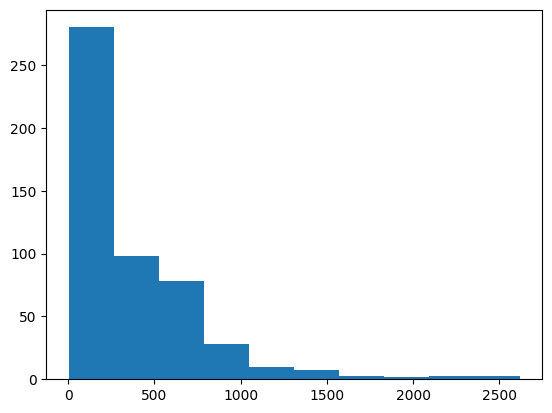

In [76]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.hist(burst_concs)

In [77]:


    
for row in df[["short_title", "prompt", "b"]].sort_values("b", ascending=False).head(30).to_dict("records"):
    print(row["short_title"], row["b"])
    print(row["prompt"])
    print("\n")
    print("==="*20)
    print("\n")
    

Privacy and Data Usage 2616.91455078125
CONTEXT:
None

KEYWORDS:
visit; dedicate; globaldata; store; personalize; device; website; content; audience; navigation; site; traffic; identifier; ad; privacy

EXAMPLES:

As part of GlobalData's extensive network of websites, this site is dedicated to protecting your privacy. We may store and access personal data such as cookies, device identifiers or other similar technologies on your device and process such data to enhance site navigation, personalize ads and content when you visit our sites, measure ad and content performance, gain audience insights, analyze our site traffic as well as develop and improve our products and services. Further information on the cookies we use and their purpose can be found on our website privacy policy accessible here.

As part of GlobalData's extensive network of websites, this site is dedicated to protecting your privacy. We may store and access personal data such as cookies, device identifiers or other simil

In [91]:
index3.id


'index_a1d01fddf2194a628fc200a9fcbae6c0'

In [110]:
index = Index(id="index_5179ffc1eebe42e481e56661883995a4", API_key="ktest2")

Found an existing index with id="index_5179ffc1eebe42e481e56661883995a4".


In [111]:
index.queryMeta("SELECT  doc_id FROM doc_meta WHERE ticker='GOOGL'")

[{'doc_id': '2df19f13c40274418d95736b10171029'},
 {'doc_id': '5b6dadbe46dc0a1866abf4f9da92e62f'},
 {'doc_id': '447472ecb2a2bf76d240b37e3de47f38'},
 {'doc_id': 'ab939654b78c43affb8eb3c8498b67dd'},
 {'doc_id': 'b07b0bc227a92a8a3bbb9af6d809b941'},
 {'doc_id': 'cabfd91c0be0fb329f18b2edafcf2593'},
 {'doc_id': '26f7fe6d9b8dba262076fcd48abc47d6'},
 {'doc_id': 'e97fb33171d20ffe0308d2eb33abcf91'},
 {'doc_id': 'c1695baf35706124489e1801ba8edbb1'},
 {'doc_id': '81d9a1f217254e0a94e076f12ec5945a'},
 {'doc_id': '1e7f33d642caca1559f9a4da9d82d830'},
 {'doc_id': 'fcfed8c55326fa8126747104f103e286'},
 {'doc_id': '82911cff632e4cd4de26575419a5af95'},
 {'doc_id': '97b5598dfd2f5dae376f7b0781f00ccc'},
 {'doc_id': '9552bd24f618700c6550f86c820c9787'},
 {'doc_id': '0b8733af9f30c3e11fdbe856a8ca281a'},
 {'doc_id': '8c90efc242d29a7cc8409e5c3b92fd9e'},
 {'doc_id': '77057282cedb257079ffc4e7852355b2'},
 {'doc_id': '416a821c3dd0c8db3e0d1f1ca0e254a7'},
 {'doc_id': '42d17805950ecff574d4fa527f73cd82'},
 {'doc_id': 'd7d5c8e

In [113]:
res = index.topicDiff(q1= " ticker='AAPL' ")

error code 400
<!doctype html>
<html lang=en>
<title>400 Bad Request</title>
<h1>Bad Request</h1>
<p>Your query did not match on any docs:  ticker=&#39;aapl&#39; </p>



AssertionError: 